In [1]:
# %%
# %%
import os
import sys
import numpy as np
import torch
# from torch.utils.data import TensorDataset, DataLoader

# DL-Kit
sys.path.append('/Users/hgoldwyn/Research/projects/SR_CNN/dl-kit') #TODO adjust path
sys.path.append('/projects/ecrpstats/dl-kit') #TODO adjust path
from dlkit.log.log_util import (logging_set_up, logging_get_logger)
# from dlkit.nets.mlp import MLPModel
from dlkit.opt.train import train_epochs
from dlkit.nets.conv2d import Conv2dUpscaleModelInterpolate

## Load model module
sys.path.append('/Users/hgoldwyn/Research/projects/SR_CNN/paper_repo/auxilary_modules') #TODO adjust path
sys.path.append('/projects/ecrpstats/distributional_SRCNN/auxilary_modules')
import data_loading
import plotting

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import pandas as pd

train_or_load = 'train'
# %%
hr_data_size = 64
lr_data_size = 8

# %%
epochs = 500
batch_size = 32
##
region = 0
subregion = 'all'

# %%
## import data
xtrainHR, xtestHR, xtrainLR, xtestLR = data_loading.import_data(
    region,
    subregion,
    train_fraction=.75, 
    order='(subregion, time)'
    )

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [36]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [37]:
device = (
    "cuda"
    if torch.cuda.is_available()
    # else "mps"
    # if torch.backends.mps.is_available()
    else "cpu"
    )
print(f"Using device: {device}")

Using device: cpu


Define basis functions

In [38]:
N = 64
def compl_dft_basis(x, y, k_x, k_y):
    return np.exp(1j * 2*np.pi * (k_x*x + k_y*y)/N)

In [39]:
x = np.arange(0, N)

xg = np.tile(x, N)            # generates x-coordinates for the entire grid N*K 
yg = np.repeat(x, N, axis=0)

mat_xg = xg.reshape((64, 64))
mat_yg = yg.reshape((64, 64))

In [40]:
## Create basis functions to max period
# max_T = 20
# min_k = int(N/max_T)
min_k = 0
print(f"min k : {min_k}")
# max_k = (N)//2
max_k = (N)//2 + 1
print(f"max k : {max_k}")

basis_function_k_idx = []
basis_functions = []
for _kx in range(min_k, max_k):
    for _ky in range(min_k, max_k):
        basis_functions.append(
            compl_dft_basis(
                mat_xg, 
                mat_yg, 
                _kx, 
                _ky
                )
            )
        basis_function_k_idx.append((_kx, _ky))
        
basis_functions = np.asarray(basis_functions).reshape((-1, 64**2)).T
basis_functions.shape

min k : 0
max k : 33


(4096, 1089)

In [41]:
## Generate complex tensor
basis_functions_tensor = torch.tensor(basis_functions, dtype=torch.complex64).to(device)

In [42]:
p5p5_cov_params = np.load(
    "../stage_2/output/parCov_fitting_fourier_allImages_mseStart_globalPrior_anal_empPriorStdOn5p5_param_fits.npy"
    )

In [43]:

def get_r(x, y):
    return np.sqrt(np.subtract.outer(x, x)**2 +  np.subtract.outer(y, y)**2)


def pow_exp_correlation(r, a=1, alpha=1): 
    """ Powered exponential correlation
        a > 0
        0 < alpha < 2
        """
    c = torch.exp(-(r/a)**alpha)
    # c[r == 0] = 1e-8
    return c

def pow_exp_cov(r, sigma, tau, a, alpha):
    """
    """
    c_term = sigma**2 * pow_exp_correlation(r, a=a, alpha=alpha)
    if c_term.ndim == 2:
        tau_term = torch.diag_embed(torch.Tensor([tau]*len(c_term)))
    elif c_term.ndim == 1:
        tau_term = torch.zeros_like(c_term)
        tau_term[0] = tau
    
    return c_term + tau_term

# K = hr_data_size
K = 64
x = np.arange(0, K)
xg = np.tile(x, K)            # generates x-coordinates for the entire grid K*K 
yg = np.repeat(x, K, axis=0)
pixel_sep = get_r(xg, yg)


In [44]:
pixel_sep_rav = pixel_sep.ravel()

In [45]:
covs = []
covs_std = []

pixel_sep_sort_args = np.argsort(pixel_sep_rav)

for i, params in enumerate(p5p5_cov_params):
    ## compute covaraince
    fit_cov = torch.real(
        torch.matmul(
            basis_functions_tensor/N, 
            torch.matmul(
                torch.diag_embed(torch.tensor(params, dtype=torch.complex64)),
                torch.conj(basis_functions_tensor.T)/N
                )
            )
        )
    
    

    _sorted = fit_cov.ravel()[pixel_sep_sort_args]
    sorted_pixel_sep = pixel_sep_rav[pixel_sep_sort_args]

    ## Use pandas to compute mean across unique pizel separations
    cov_series = pd.DataFrame(_sorted, sorted_pixel_sep)
    cov_series_mean = cov_series.groupby(cov_series.index.round(0)).mean()
    cov_series_stdd = cov_series.groupby(cov_series.index.round(0)).std()

    covs.append(cov_series_mean)
    covs_std.append(cov_series_stdd)


In [46]:
covs_np = np.array([cov.values for cov in covs])
covs_std_np = np.array([cov.values for cov in covs_std])

In [47]:
covs_np = covs_np.squeeze()
covs_std_np = covs_std_np.squeeze()

In [48]:
np.save('p5p5_cov_per_pixel_sep_per_img.npy', covs_np)
np.save('p5p5_cov_per_pixel_sep_per_img_stdd.npy', covs_std_np)

covs_np_p5p5 = np.load('p5p5_cov_per_pixel_sep_per_img.npy')
covs_std_np_p5p5 = np.load('p5p5_cov_per_pixel_sep_per_img_stdd.npy')

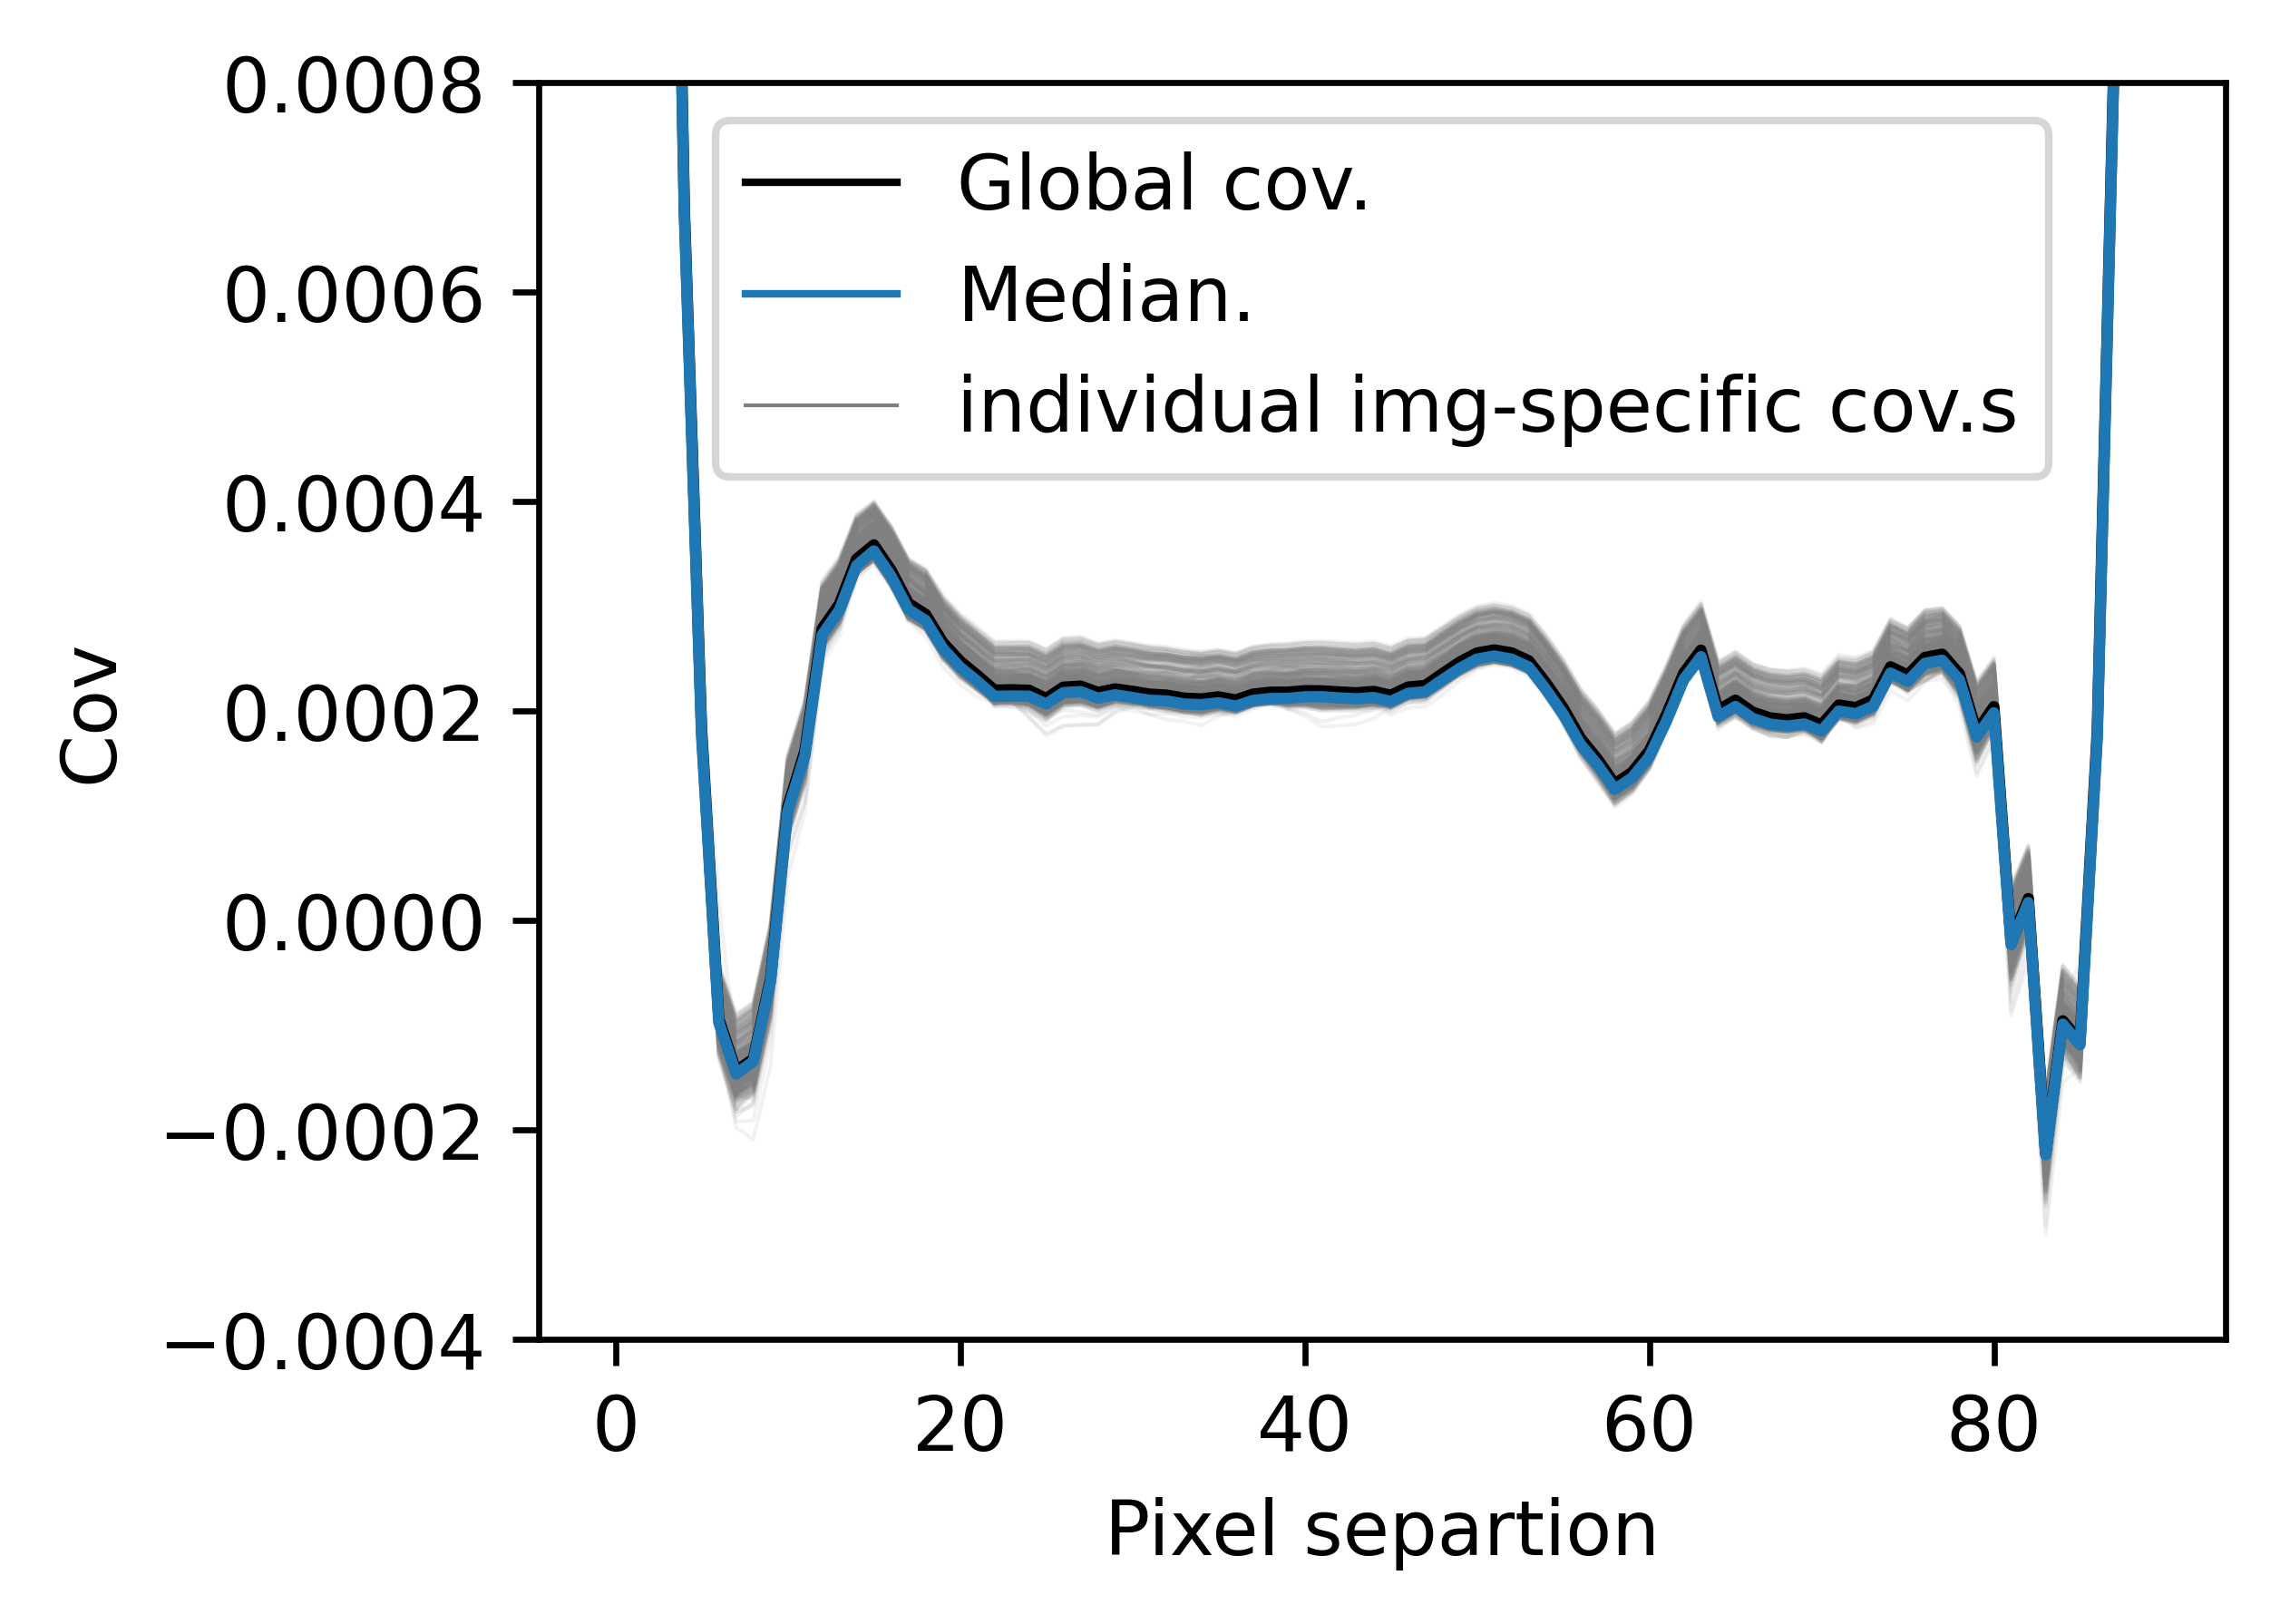

In [49]:
plt.figure(dpi=600, figsize=(4, 3))

# fit_params = minimized_params.detach()

plt.plot(range(90), covs_np_p5p5.mean(axis=0), color='k', label='mean')
plt.plot(range(90), np.median(covs_np_p5p5, axis=0), color='C0', label='median')

for i, cov in enumerate(covs_np_p5p5):
    if i == 0:
        _label = 'individual img-specific cov.s'
    else:
        _label = None
    plt.plot(range(90), cov, alpha=0.1, color='gray', zorder = 0, lw=.5, label=_label)


plt.ylabel('Cov')
plt.xlabel('Pixel separtion')
# plt.legend()
# plt.ylim((-0.0025, 0.01))
plt.ylim((-0.0004, 0.0008))

## ~~~ Legend ~~~
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

custom_handles = [
    Line2D([0], [0], color='black', linewidth=1, label='Global cov.'),
    Line2D([0], [0], color='C0', linewidth=1, label='Median.'),
    Line2D([], [], color='gray', linewidth=0.5, label='individual img-specific cov.s'),
]

plt.gca().legend(handles=custom_handles, loc='upper center', fontsize=10, frameon=True)


In [50]:
## Get unregularized results for figure

In [51]:
unreg_covs_np = np.load('unreg_cov_per_pixel_sep_per_img.npy')
unreg_covs_std_np = np.load('unreg_cov_per_pixel_sep_per_img_stdd.npy')

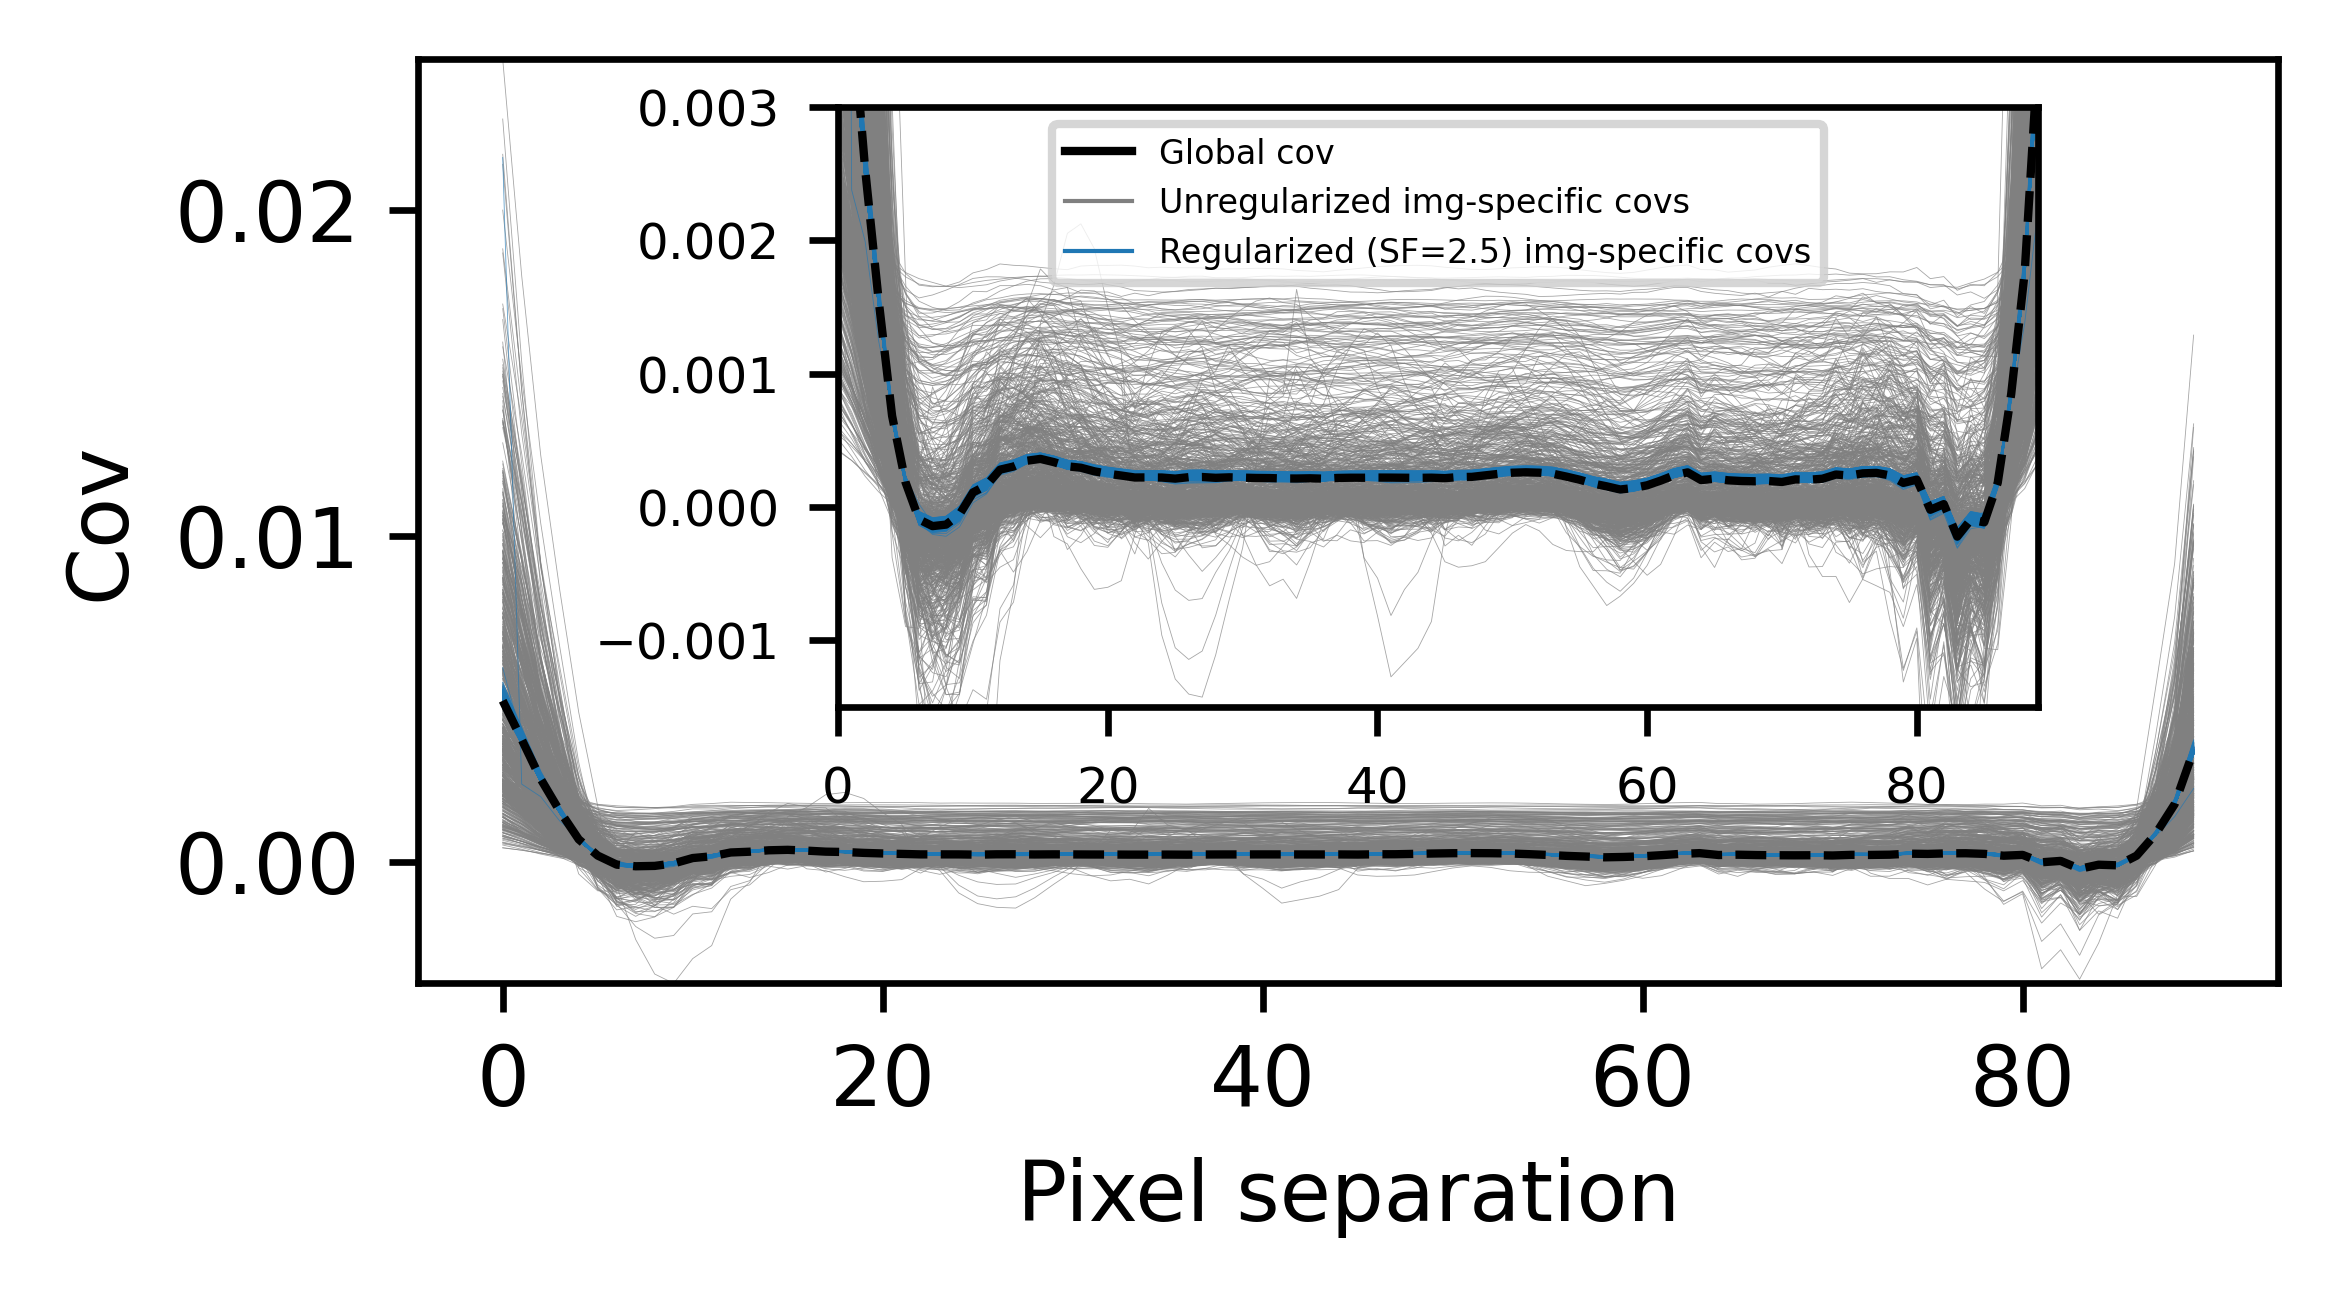

In [22]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

plt.figure(dpi=600, figsize=(4, 2))

_x = range(unreg_covs_np.shape[1])

# Main plot: full y-range (no "slim restrictions")
plt.plot(_x, unreg_covs_np.mean(axis=0), color='k', ls='--', lw=1, label='global covariance')
for i, cov in enumerate(unreg_covs_np):
    _label = 'individual img-specific cov.s' if i == 0 else None
    plt.plot(_x, cov, alpha=0.7, color='gray', zorder=0, lw=0.1, label=_label)

plt.ylabel('Cov')
plt.xlabel('Pixel separation')
plt.ylim(unreg_covs_np.min(), unreg_covs_np.max())  # full range
ax = plt.gca()

# ~~~ Inset axes with slim y-axis range ~~~
ax_inset = inset_axes(ax, width="50%", height="50%", loc='upper center',
                      bbox_to_anchor=(0.05, -0.125, 1, 1), bbox_transform=plt.gcf().transFigure)

ax_inset.plot(_x, unreg_covs_np.mean(axis=0), color='k', ls='--', lw=1)
for cov in unreg_covs_np:
    ax_inset.plot(_x, cov, alpha=0.7, color='gray', zorder=0, lw=0.1)

ax_inset.set_ylim(-0.0015, 0.003)  # slim view
ax_inset.set_xlim(_x[0], _x[-1])  # optional: match full x-range
ax_inset.tick_params(labelsize=6)
# ax_inset.set_title("Zoom", fontsize=8)

## Plot regularized output
for _ax in [ax, ax_inset]:
    # _ax.plot(range(90), covs_np_p2p5.mean(axis=0), color='k', label='mean')
    # _ax.plot(range(90), np.median(covs_np_p2p5, axis=0), color='C0', label='median')

    for i, cov in enumerate(covs_np_p5):
        if i == 0:
            _label = 'individual img-specific cov.s'
        else:
            _label = None
        _ax.plot(range(90), cov, alpha=0.7, color='C0', zorder = 0, lw=0.1, label=_label)

custom_handles = [
    Line2D([0], [0], color='black', linewidth=1, label='Global cov'),
    Line2D([], [], color='gray', linewidth=0.5, label='Unregularized img-specific covs'),
    Line2D([], [], color='C0', linewidth=0.5, label='Regularized (SF=2.5) img-specific covs'),
]
ax_inset.legend(handles=custom_handles, loc='upper center', fontsize=4, frameon=True)

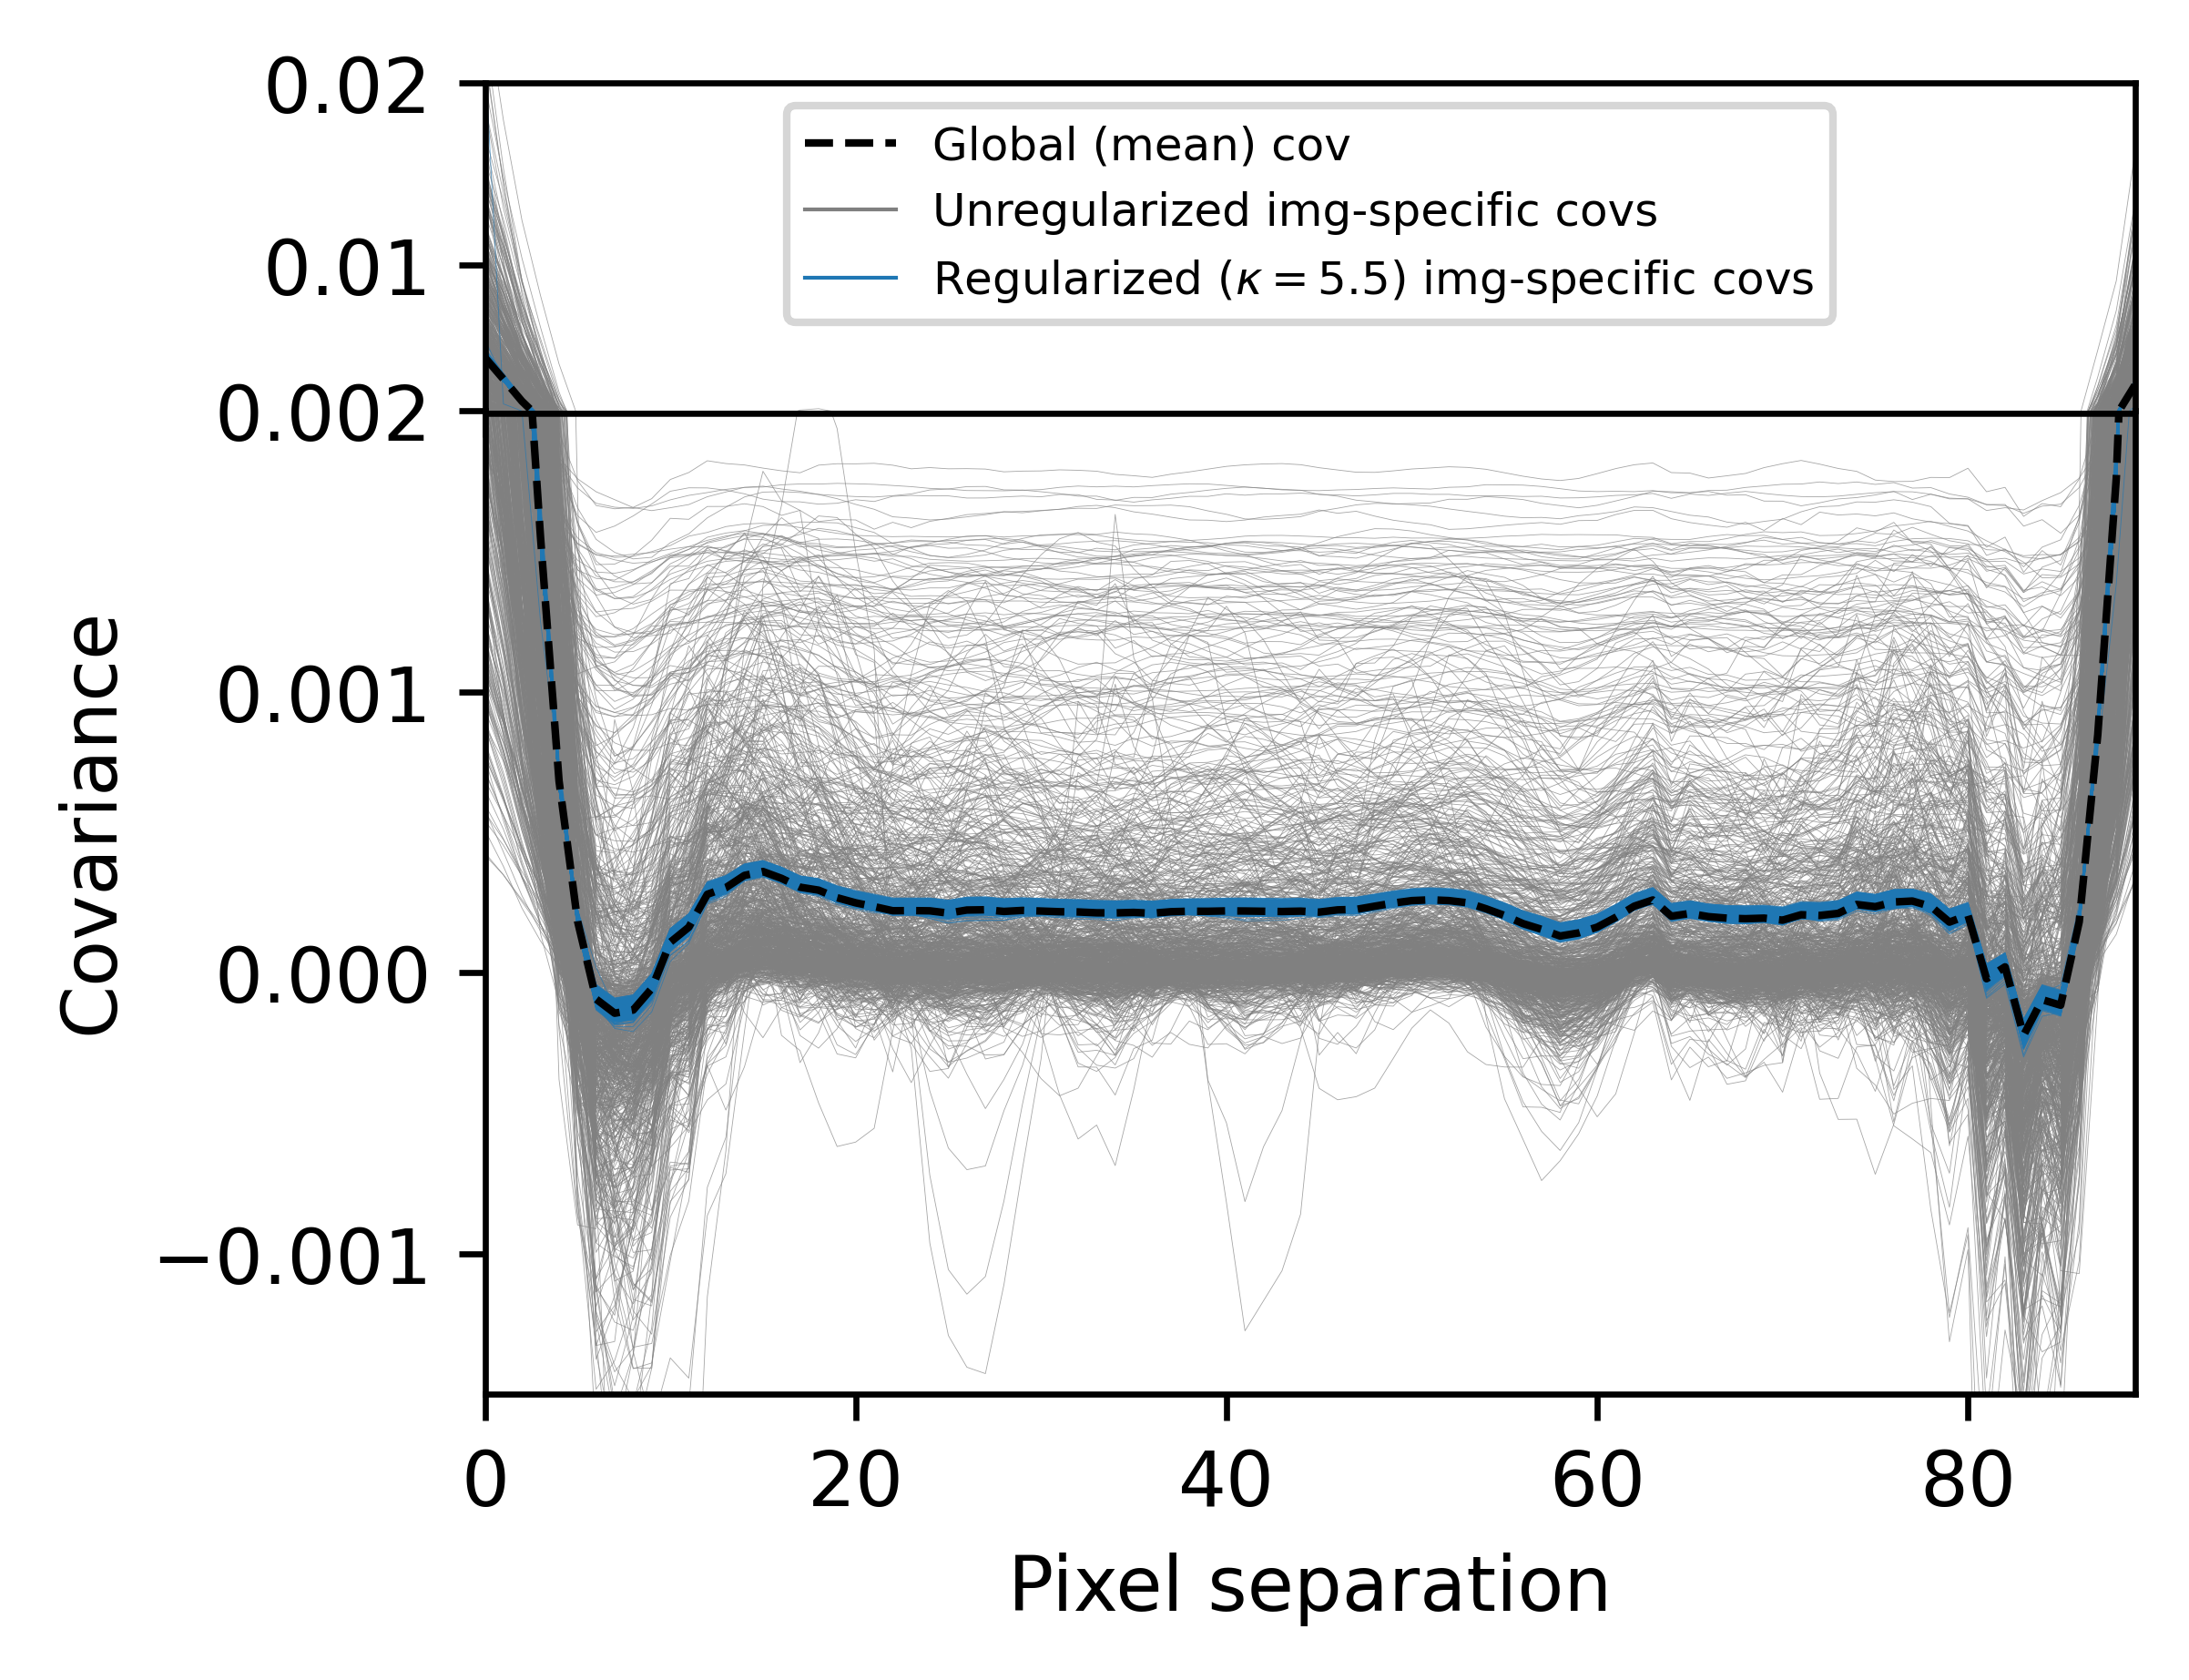

In [53]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec

# Assuming unreg_covs_np and covs_np_p5p5 are already defined NumPy arrays
_x = range(unreg_covs_np.shape[1])

# Create a figure with two vertically stacked axes (split y-axis)
fig = plt.figure(dpi=600, figsize=(4, 3))
gs = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[1, 3], hspace=0.0)

ax_top = fig.add_subplot(gs[0])
ax_bot = fig.add_subplot(gs[1], sharex=ax_top)

# Plot unregularized covariances
for i, cov in enumerate(unreg_covs_np):
    label = 'Unreg. img-specific covs' if i == 0 else None
    ax_top.plot(_x, cov, alpha=0.7, color='gray', lw=0.1, zorder=0, label=label)
    ax_bot.plot(_x, cov, alpha=0.7, color='gray', lw=0.1, zorder=0)

# Plot global mean
ax_top.plot(_x, unreg_covs_np.mean(axis=0), color='k', ls='--', lw=1, label='Global cov')
ax_bot.plot(_x, unreg_covs_np.mean(axis=0), color='k', ls='--', lw=1)

# Plot regularized covariances
for i, cov in enumerate(covs_np_p5p5):
    label = 'Reg. (SF=5) img-specific covs' if i == 0 else None
    ax_top.plot(_x, cov, alpha=0.7, color='C0', lw=0.1, zorder=0, label=label)
    ax_bot.plot(_x, cov, alpha=0.7, color='C0', lw=0.1, zorder=0)

# Set y-limits to "break" the axis
axis_break = 0.002
ax_top.set_ylim(axis_break, 0.02)
ax_bot.set_ylim(-0.0015, axis_break)

# Hide spines between the axes and suppress redundant x-ticks
ax_top.spines['bottom'].set_visible(False)
ax_bot.spines['top'].set_visible(False)
ax_top.tick_params(labelbottom=False)

# Shared axis labels
ax_bot.set_xlabel('Pixel separation')
# ax_top.set_ylabel('Cov')
# ax_bot.set_ylabel('Cov')
fig.text(0.045, 0.5, 'Covariance', ha='center', va='center', rotation='vertical')


# Optional dashed horizontal line to indicate break
ax_bot.plot([_x[0], _x[-1]], [axis_break, axis_break], ls='-', color='k', lw=1.5)
ax_bot.set_xlim([_x[0], _x[-1]])

# Custom legend
custom_handles = [
    Line2D([0], [0], color='black', linewidth=1, linestyle='--', label='Global (mean) cov'),
    Line2D([], [], color='gray', linewidth=0.5, label='Unregularized img-specific covs'),
    Line2D([], [], color='C0', linewidth=0.5, label='Regularized ($\kappa=5.5$) img-specific covs'),
]
ax_top.legend(handles=custom_handles, loc='upper center', fontsize=6, frameon=True)

# Adjust layout manually (instead of tight_layout)
plt.subplots_adjust(left=0.225, right=0.98, bottom=0.15, top=0.95, hspace=0.0,)


In [75]:
# 